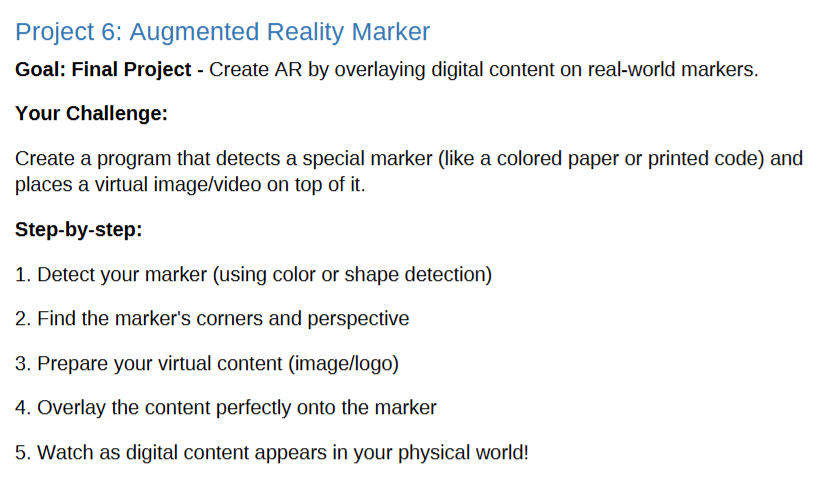

In [12]:
import cv2 as cv
import numpy as np

In [24]:
cap = cv.VideoCapture(0)

# AR ÇERÇEVE PNG (RGBA)
overlay = cv.imread("frame_1.png", cv.IMREAD_UNCHANGED)

# Kaynak çerçevenin köşe noktaları
h_o, w_o = overlay.shape[:2]
src_pts = np.array([
    [0, 0],
    [w_o, 0],
    [w_o, h_o],
    [0, h_o]
], dtype=np.float32)

def order_points(pts):
    pts = np.array(pts).reshape(4, 2)
    ordered = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    ordered[0] = pts[np.argmin(s)]      # sol üst
    ordered[2] = pts[np.argmax(s)]      # sağ alt

    diff = np.diff(pts, axis=1)
    ordered[1] = pts[np.argmin(diff)]   # sağ üst
    ordered[3] = pts[np.argmax(diff)]   # sol alt

    return ordered

while True:
    ret, frame = cap.read()
    frame = cv.flip(frame, 1)

    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    # Kırmızı maske
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2

    # Temizleme
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9, 9))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=3)

    # Contour bul
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv.contourArea)

        if cv.contourArea(largest) > 5000:

            # Çokgen yaklaştırma → köşeleri bulur
            epsilon = 0.03 * cv.arcLength(largest, True)
            approx = cv.approxPolyDP(largest, epsilon, True)

            if len(approx) == 4:
                dst_pts = order_points(approx)

                # Homography hesapla
                H, _ = cv.findHomography(src_pts, dst_pts)

                # Overlay'i hedef görüntüde bük
                warped = cv.warpPerspective(overlay, H, (frame.shape[1], frame.shape[0]))

                # Alfa maske
                alpha = warped[:, :, 3] / 255.0
                warped_rgb = warped[:, :, :3]

                for c in range(3):
                    frame[:, :, c] = warped_rgb[:, :, c] * alpha + frame[:, :, c] * (1 - alpha)

                # Köşeleri göster (debug)
                for p in dst_pts:
                    cv.circle(frame, tuple(p.astype(int)), 6, (255, 0, 0), -1)

    cv.imshow("AR FRAME", frame)
    cv.imshow("MASK", mask)

    if cv.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv.destroyAllWindows()
